### libs

In [1]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

In [2]:
import math
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F


class Morphology(nn.Module):
    '''
    Base class for morpholigical operators
    For now, only supports stride=1, dilation=1, kernel_size H==W, and padding='same'.
    '''
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        '''
        in_channels: scalar
        out_channels: scalar, the number of the morphological neure.
        kernel_size: scalar, the spatial size of the morphological neure.
        soft_max: bool, using the soft max rather the torch.max(), ref: Dense Morphological Networks: An Universal Function Approximator (Mondal et al. (2019)).
        beta: scalar, used by soft_max.
        type: str, dilation2d or erosion2d.
        '''
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

    def forward(self, x):
        '''
        x: tensor of shape (B,C,H,W)
        '''
        # padding
        x = fixed_padding(x, self.kernel_size, dilation=1)

        # unfold
        x = self.unfold(x)  # (B, Cin*kH*kW, L), where L is the numbers of patches
        x = x.unsqueeze(1)  # (B, 1, Cin*kH*kW, L)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        # erosion
        weight = self.weight.view(self.out_channels, -1) # (Cout, Cin*kH*kW)
        weight = weight.unsqueeze(0).unsqueeze(-1)  # (1, Cout, Cin*kH*kW, 1)

        if self.type == 'erosion2d':
            x = weight - x # (B, Cout, Cin*kH*kW, L)
        elif self.type == 'dilation2d':
            x = weight + x # (B, Cout, Cin*kH*kW, L)
        else:
            raise ValueError

        if not self.soft_max:
            x, _ = torch.max(x, dim=2, keepdim=False) # (B, Cout, L)
        else:
            x = torch.logsumexp(x*self.beta, dim=2, keepdim=False) / self.beta # (B, Cout, L)

        if self.type == 'erosion2d':
            x = -1 * x

        # instead of fold, we use view to avoid copy
        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)  # (B, Cout, L/2, L/2)

        return x

class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')

class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')



def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


if __name__ == '__main__':
    # test
    x=torch.randn(2,3,16,16)
    e=Erosion2d(3, 4, 3, soft_max=False)
    y=e(x)

### Nets

In [3]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=1):
        super(UNet, self).__init__()

        features = init_features
        pool_stride = 2
        pool_kernel = 2

        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)

        self.bottleneck = UNet._block(features * 2, features * 4, name="bottleneck")

        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=pool_kernel, stride=pool_stride
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=pool_kernel, stride=pool_stride
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))



    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True))
                ]
            )
        )

In [4]:
m = UNet()
m(torch.empty(1,1,28,28)).shape

torch.Size([1, 1, 28, 28])

In [5]:
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, channels):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.linear_layer = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.linear_layer(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        image = self.conv_layers(out)
        return image


class Discriminator(nn.Module):
    def __init__(self, channels, img_size):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_layers = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # self.ds_size = img_size // 2 ** 4 # for img_size = 96
        self.ds_size = 2 # for img_size = 28
        self.adverse_layer = nn.Sequential(nn.Linear(128 * self.ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, image):
        out = self.conv_layers(image)
        out = out.view(out.shape[0], -1)
        validity = self.adverse_layer(out)
        return validity

In [6]:
class Mask(nn.Module):
    def __init__(self, img_size):
        super(Mask, self).__init__()

        self.img_size = img_size

        features = math.prod(img_size)
        self.net = nn.Sequential(
            nn.Linear(features, features),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(
                x.flatten(start_dim=1)
            ).view((1, 1,) + self.img_size)
        return x

In [7]:
x = torch.ones((1,1,28,28)).cuda()
m = Mask((28,28)).cuda()
m(x).shape

torch.Size([1, 1, 28, 28])

### Helper

In [8]:
def normalization(x):
    """
    Args:
        x : np.array : (H, W)

    Return:
        np.array : (H, W)
    """
    x = x + np.absolute(x.min(keepdims=True))
    x = x / x.max(keepdims=True)
    return  x

In [9]:
def denoising(mask, kernel_size):
    blurred_img = cv2.medianBlur(mask, 5)

    kernel = np.ones((kernel_size,kernel_size))
    erosion = cv2.erode(blurred_img, kernel, iterations=1)
    output = cv2.dilate(erosion, kernel, iterations=1)

    return output

In [10]:
def back_mask(corrupted_images, generated_images):
    corrupted_images = 1 - normalization(corrupted_images)
    generated_images = 1 - normalization(generated_images)
    mask = corrupted_images/generated_images
    mask[np.isnan(mask)] = 0
    return mask

In [11]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [12]:
def ploter(corrupted_images, generated_images, original_images):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,3,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(corrupted_images)
    plt.tight_layout()
    plt.title("corrupted")

    plt.subplot(1,3,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(generated_images)
    plt.tight_layout()
    plt.title("generated")

    plt.subplot(1,3,3)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(original_images)
    plt.tight_layout()
    plt.title("original")

    plt.show()

In [13]:
def context_loss(corrupted_images, generated_images, masks, weighted=True):
    return torch.sum(((corrupted_images-generated_images)**2)*masks)

In [14]:
def get_weighted_mask(mask,window_size):
    assert len(mask.shape) == 3
    assert window_size % 2 == 1 # odd window size
    max_shift = window_size//2
    output = np.zeros_like(mask)
    for i in range(-max_shift,max_shift+1):
        for j in range(-max_shift,max_shift+1):
            if i != 0 or j != 0:
                output += np.roll(mask, (i,j), axis=(1,2))
    output = 1 - output/(window_size**2-1)
    return output*mask

In [15]:
def get_weighted_mask(mask,window_size):
    assert len(mask.shape) == 3
    assert window_size % 2 == 1 # odd window size
    max_shift = window_size//2
    output = np.zeros_like(mask)
    for i in range(-max_shift,max_shift+1):
        for j in range(-max_shift,max_shift+1):
            if i != 0 or j != 0:
                output += np.roll(mask, (i,j), axis=(1,2))
    output = 1 - output/(window_size**2-1)
    return output*mask

### Dataset

In [16]:
def get_index(class_num, dataset, mode:str):
    if mode == 'train':
        class_indx = torch.nonzero(
                dataset.train_labels == class_num * torch.ones_like(dataset.train_labels)
        )

    if mode == 'test':
        class_indx = torch.nonzero(
                dataset.test_labels == class_num * torch.ones_like(dataset.test_labels)
        )

    class_indx = class_indx.squeeze(1)
    return class_indx

In [17]:
def mask_maker(image_size):

    mask = np.ones(image_size,dtype=np.float32)
    x = np.random.randint(image_size[0]//6,5*image_size[0]//6)
    y = np.random.randint(image_size[1]//6,5*image_size[1]//6)
    h = np.random.randint(image_size[0]//5,image_size[0]//3)
    w = np.random.randint(image_size[1]//5,image_size[1]//3)
    mask[max(0,x-h//2):min(image_size[0],x+h//2),max(0,y-w//2):min(image_size[1],y+w//2)] = 0

    return mask

### Hyperparameters

In [18]:
root_best_model = "epoch220_disloss24.18_genloss52.93.pt"

window_size = 25 #??
batch_size = 1
num_sub = 1

img_size = 28
latent_dim = 100
channels = 1

optim_steps = 1000 # ???
sample_interval = 100

prior_weight = 0.003 # ???

### Dataset

In [19]:
root_ds = "./MNIST"

In [20]:
trans=transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,) , (0.5,))
])

test_data=datasets.MNIST(root=root_ds,
                          train=False, transform=trans, download=True)

In [21]:
test_sampler = SubsetRandomSampler(get_index(8, test_data, 'test'))
test_loader=DataLoader(test_data, batch_size= 100, sampler=test_sampler)

B:\Anaconda_install_path\envs\deeplearning\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [22]:
for original_images, _ in test_loader:
    original_images=original_images
    break
original_images = original_images[0:1]

In [23]:
# Loading trained GAN model
saved_gan = torch.load(root_best_model)

generator = Generator(img_size=img_size, latent_dim=latent_dim, channels=channels).cuda()
discriminator = Discriminator(channels=channels, img_size=img_size).cuda()

generator.load_state_dict(saved_gan["state_dict_G"])
discriminator.load_state_dict(saved_gan["state_dict_D"])

<All keys matched successfully>

### Corrupted Image

In [24]:
"""
# mask = self.mask.reshape((1,)+self.mask.shape)
#target_image[0][1-self.mask > 0.5] = np.max(target_image)
mask = mask_maker((28,28))
corrupted_images = original_images[0,0,:,:] * mask
corrupted_images = corrupted_images.unsqueeze(0).unsqueeze(0)
plt.imshow(corrupted_images[0][0])
"""

'\n# mask = self.mask.reshape((1,)+self.mask.shape)\n#target_image[0][1-self.mask > 0.5] = np.max(target_image)\nmask = mask_maker((28,28))\ncorrupted_images = original_images[0,0,:,:] * mask\ncorrupted_images = corrupted_images.unsqueeze(0).unsqueeze(0)\nplt.imshow(corrupted_images[0][0])\n'

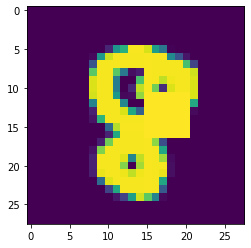

In [25]:
original_mask = mask_maker((28,28))
corrupted_images = original_images.numpy()[0].copy()
corrupted_images[0][1-original_mask > 0.5] = corrupted_images.max()
plt.imshow(corrupted_images[0])

C:\Users\khali\AppData\Local\Temp/ipykernel_15776/1691394351.py:4: RuntimeWarning: invalid value encountered in true_divide
  mask = corrupted_images/generated_images


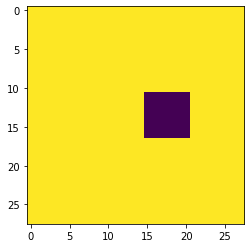

In [26]:
plt.imshow(
    back_mask(corrupted_images[0], generated_images=original_images.numpy()[0][0])
)

In [27]:
unet = UNet(1,1,32).cuda()

original_mask = torch.tensor(
    mask_maker((28,28))
    ).view(1,1,28,28).cuda()

input_ones = torch.ones_like(original_mask).to(torch.float).cuda()

ciritic = nn.MSELoss()
optim_unet = optim.Adam(unet.parameters(), lr=0.05)

In [28]:
for epoch in range(100):
    optim_unet.zero_grad()
    mask_hat = unet(input_ones)
    loss = ciritic(mask_hat, original_mask)
    loss.backward()
    optim_unet.step()
    print(f"Epoch : {epoch} \t Loss : {loss.item()}")

Epoch : 0 	 Loss : 0.2300581932067871
Epoch : 1 	 Loss : 0.11737176030874252
Epoch : 2 	 Loss : 0.05038914456963539
Epoch : 3 	 Loss : 0.030371729284524918
Epoch : 4 	 Loss : 0.027058351784944534
Epoch : 5 	 Loss : 0.02640524134039879
Epoch : 6 	 Loss : 0.02623048797249794
Epoch : 7 	 Loss : 0.02598140388727188
Epoch : 8 	 Loss : 0.02554759569466114
Epoch : 9 	 Loss : 0.024960240349173546
Epoch : 10 	 Loss : 0.02408173494040966
Epoch : 11 	 Loss : 0.02283596619963646
Epoch : 12 	 Loss : 0.02134404331445694
Epoch : 13 	 Loss : 0.019893495365977287
Epoch : 14 	 Loss : 0.01915195770561695
Epoch : 15 	 Loss : 0.01863769069314003
Epoch : 16 	 Loss : 0.017757423222064972
Epoch : 17 	 Loss : 0.016469676047563553
Epoch : 18 	 Loss : 0.01576259732246399
Epoch : 19 	 Loss : 0.01565861701965332
Epoch : 20 	 Loss : 0.015018417499959469
Epoch : 21 	 Loss : 0.014688530005514622
Epoch : 22 	 Loss : 0.014641165733337402
Epoch : 23 	 Loss : 0.014582150615751743
Epoch : 24 	 Loss : 0.014503168873488903


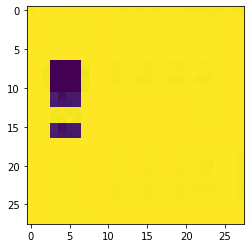

In [29]:
plt.imshow(
    unet(input_ones).detach().cpu()[0][0]
)

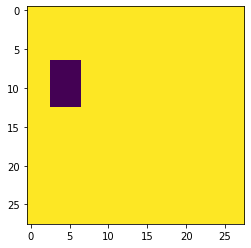

In [30]:
plt.imshow(
    original_mask[0][0].cpu()
)

### Phase 1 [Unet]

In [52]:
threshold = 0.1

z_optimum = nn.Parameter(torch.FloatTensor(np.random.normal(0, 1, (batch_size,latent_dim,))).cuda())

unet = UNet(1,1,16).cuda()

optimizer_inpaint = optim.Adam([z_optimum])
optimizer_unet = optim.Adam(unet.parameters(), lr=0.05)

ciritic = nn.MSELoss()

C:\Users\khali\AppData\Local\Temp/ipykernel_15776/860912455.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  corrupted_images = torch.tensor(corrupted_images).view(1,1,28,28).cuda()
C:\Users\khali\AppData\Local\Temp/ipykernel_15776/1691394351.py:4: RuntimeWarning: invalid value encountered in true_divide
  mask = corrupted_images/generated_images


##### Epoch : 100 ####################


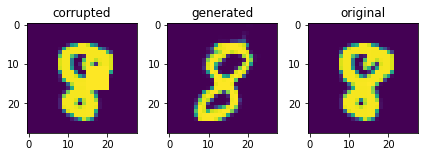

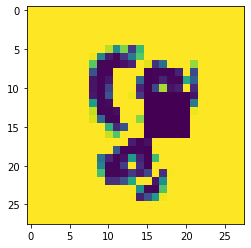

##### Epoch : 200 ####################


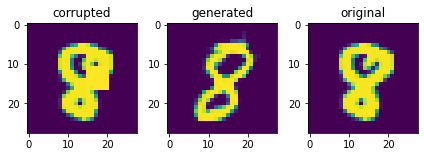

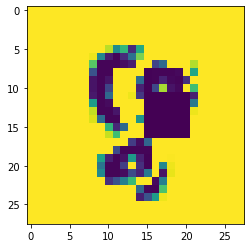

C:\Users\khali\AppData\Local\Temp/ipykernel_15776/1691394351.py:4: RuntimeWarning: divide by zero encountered in true_divide
  mask = corrupted_images/generated_images


##### Epoch : 300 ####################


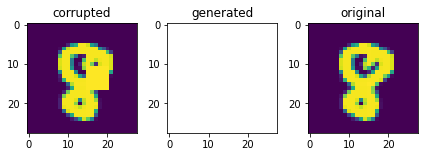

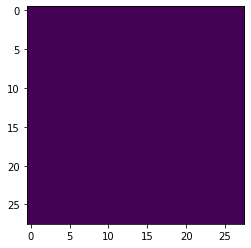

##### Epoch : 400 ####################


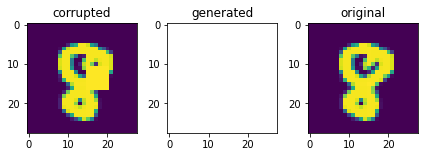

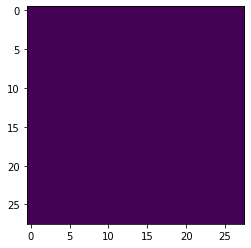

##### Epoch : 500 ####################


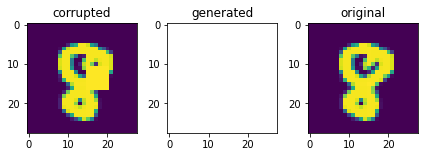

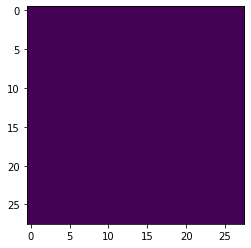

##### Epoch : 600 ####################


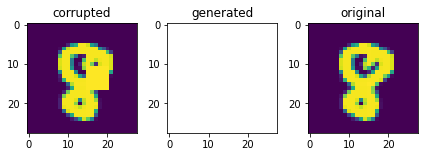

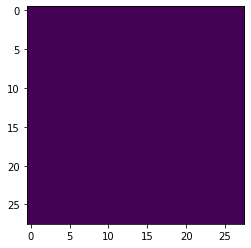

KeyboardInterrupt: 

In [53]:
corrupted_images = torch.tensor(corrupted_images).view(1,1,28,28).cuda()
for epoch in range(1, 1000+1):


    mask_hat = unet(torch.ones(1,1,28,28).to(torch.float).cuda())
    weighted_masks = get_weighted_mask(mask_hat[0].detach().cpu().numpy(),window_size=3)

    # z optimum
    optimizer_inpaint.zero_grad()
    optimizer_unet.zero_grad()

    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())
    prior_loss = torch.sum(-torch.log(discriminator_opinion))

    #l1_norm = sum(p.abs().sum() for p in mask_hat)

    #mask_hat_ = back_mask(corrupted_images.detach().cpu().numpy()[0][0],generator(z_optimum).detach().cpu().numpy()[0][0])
    #mask_hat = mask_hat_.copy()
    #mask_hat[mask_hat>threshold] = 1

    label = torch.tensor(back_mask(corrupted_images.detach().cpu().numpy()[0][0],
                     generator(z_optimum).detach().cpu().numpy()[0][0])
                         ).view(1,1,28,28).cuda()

    unet_loss = ciritic(mask_hat,label)

    inpaint_loss = c_loss + prior_loss + 0.1*unet_loss#+ 0.1*l1_norm
    inpaint_loss.backward()

    optimizer_inpaint.step()
    optimizer_unet.step()

    if epoch % 100==0:
        print(f"##### Epoch : {epoch} ####################")
        num_rnd = 0
        ploter(corrupted_images[num_rnd,0].detach().cpu(),
            generated_images[num_rnd,0].detach().cpu(),
            original_images[num_rnd,0].detach().cpu())

        plt.figure()
        plt.imshow(label.detach().cpu()[0][0] ,vmin=0, vmax=1)
        plt.show()

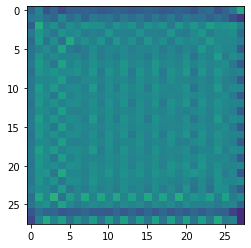

In [53]:
plt.figure()
plt.imshow(mask_hat.detach().cpu()[0][0], vmin=0, vmax=1)
plt.show()

In [ ]:
layers = []
for n, p in named_parameters:
    if (p.requires_grad) and ("bias" not in n):
        layers += [n]

### Phase 1

In [195]:
threshold = 0.1

z_optimum = nn.Parameter(torch.FloatTensor(np.random.normal(0, 1, (batch_size,latent_dim,))).cuda())
mask_net = Mask((14,14)).cuda()

optimizer_inpaint = optim.Adam([z_optimum])
optimizer_mask = optim.Adam(mask_net.parameters())

down_sampler = nn.Upsample(size=(14,14), mode='nearest')
up_sampler = nn.Upsample(size=(28,28), mode='nearest')

In [204]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [205]:
count_parameters(mask_net)

38612

C:\Users\khali\AppData\Local\Temp/ipykernel_3564/1857069021.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  corrupted_images = torch.tensor(corrupted_images).view(1,1,28,28).cuda()
C:\Users\khali\AppData\Local\Temp/ipykernel_3564/1691394351.py:4: RuntimeWarning: divide by zero encountered in true_divide
  mask = corrupted_images/generated_images


##### Epoch : 100 ####################


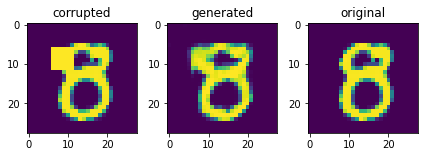

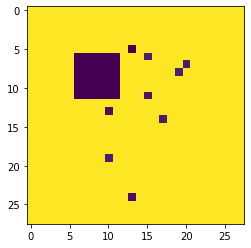

##### Epoch : 200 ####################


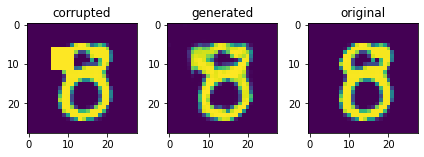

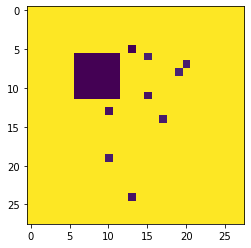

##### Epoch : 300 ####################


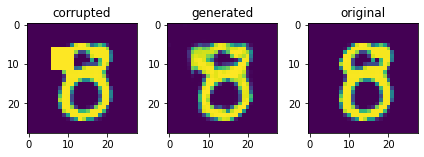

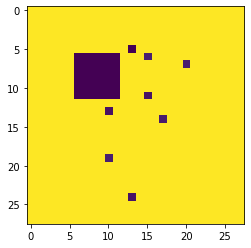

##### Epoch : 400 ####################


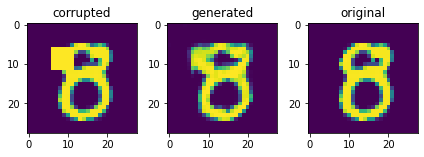

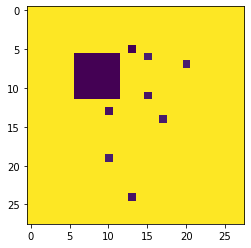

##### Epoch : 500 ####################


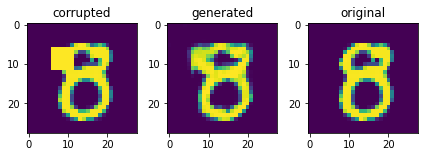

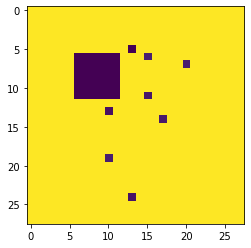

##### Epoch : 600 ####################


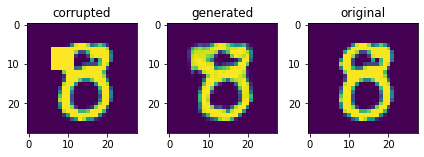

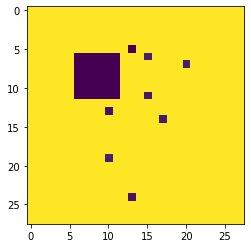

##### Epoch : 700 ####################


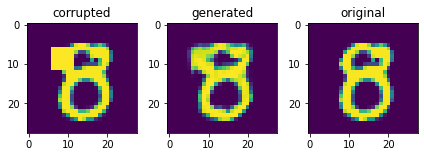

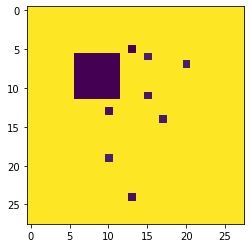

##### Epoch : 800 ####################


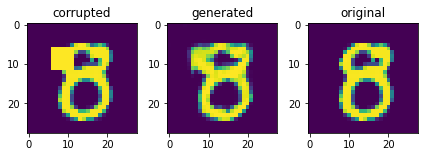

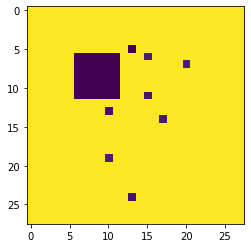

##### Epoch : 900 ####################


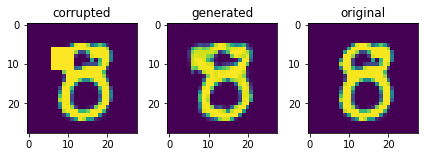

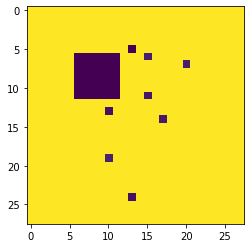

##### Epoch : 1000 ####################


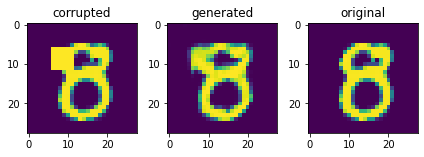

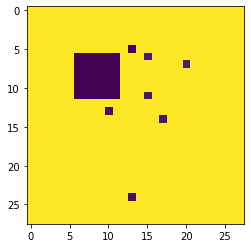

In [202]:
corrupted_images = torch.tensor(corrupted_images).view(1,1,28,28).cuda()
for epoch in range(1, 1000+1):

    # mask
    mask_hat_ = back_mask(corrupted_images.detach().cpu().numpy()[0][0],
                     generator(z_optimum).detach().cpu().numpy()[0][0])
    mask_hat = mask_hat_.copy()
    mask_hat[mask_hat>threshold] = 1

    mask_hat = torch.tensor(mask_hat).view(1,1,28,28).cuda()
    mask_hat = down_sampler(mask_hat)
    mask_hat = mask_net(mask_hat)
    mask_hat = up_sampler(mask_hat)
    weighted_masks = get_weighted_mask(mask_hat[0].detach().cpu().numpy(),window_size=7)

    # z optimum
    optimizer_inpaint.zero_grad()
    optimizer_mask.zero_grad()
    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())
    prior_loss = torch.sum(-torch.log(discriminator_opinion))

    #l1_norm = sum(p.abs().sum() for p in mask_hat)
    l1_norm = (
            mask_hat - torch.ones_like(mask_hat)
    ).abs().sum()

    inpaint_loss = c_loss + 0.5*prior_loss #+ 0.1*l1_norm
    inpaint_loss.backward()

    optimizer_inpaint.step()
    optimizer_mask.step()

    if epoch % 100==0:
        print(f"##### Epoch : {epoch} ####################")
        num_rnd = 0
        ploter(corrupted_images[num_rnd,0].detach().cpu(),
            generated_images[num_rnd,0].detach().cpu(),
            original_images[num_rnd,0].detach().cpu())

        plt.figure()
        mask_hat_ = back_mask(corrupted_images.detach().cpu().numpy()[0][0],
                     generator(z_optimum).detach().cpu().numpy()[0][0])
        mask_hat = mask_hat_.copy()
        mask_hat[mask_hat>threshold] = 1
        plt.imshow(mask_hat, vmin=0, vmax=1)
        plt.show()

In [ ]:
mask_hat.shape

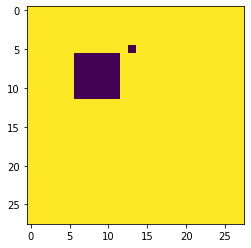

In [203]:
mask_hat_ = mask_hat
mask_hat_[mask_hat_>0.01] = 1
plt.imshow(mask_hat_)

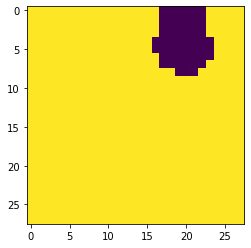

In [139]:
mask_hat_ = denoising(mask_hat_, 3)
plt.imshow(
    denoising(mask_hat_, 3)
)

### Phase2

In [ ]:
mask_hat = mask_hat_

In [ ]:
mask_hat = cv2.medianBlur(mask_hat, 3)
mask_hat = mask_hat.reshape(1,1,28,28)
mask_hat = torch.tensor(mask_hat)
# mask
weighted_masks = get_weighted_mask(mask_hat[0].detach().cpu().numpy(),window_size=3)

In [ ]:
plt.imshow(mask_hat[0][0])

In [179]:
z_optimum = nn.Parameter(torch.FloatTensor(np.random.normal(0, 1, (batch_size,latent_dim,))).cuda())
optimizer_inpaint = optim.Adam([z_optimum])

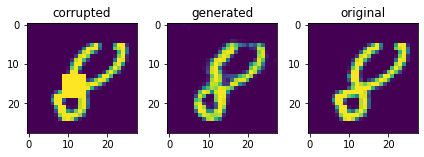

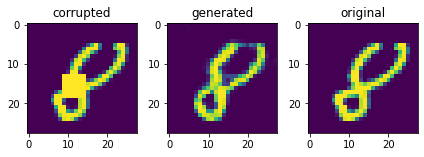

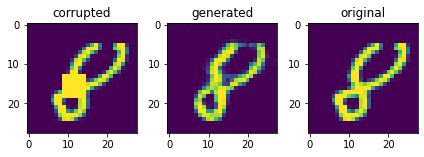

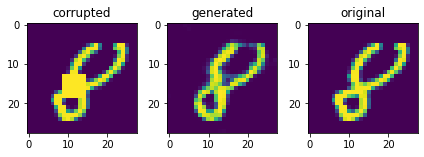

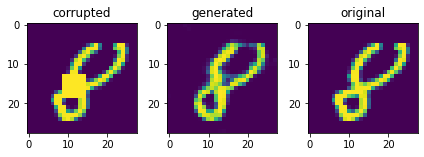

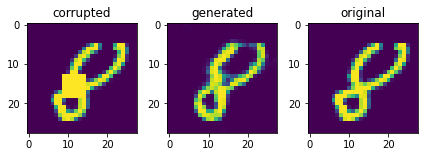

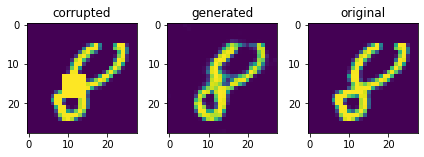

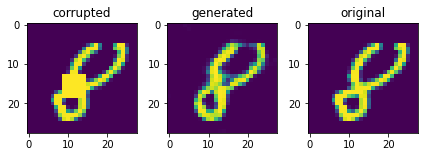

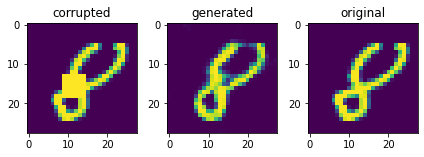

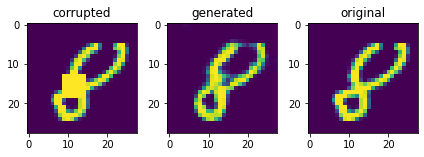

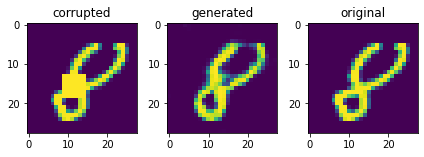

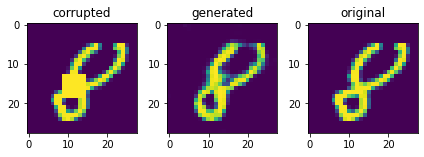

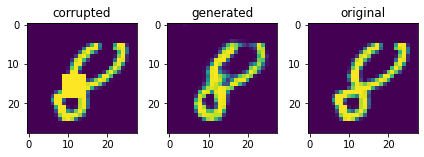

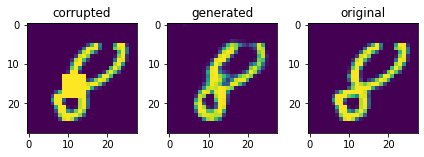

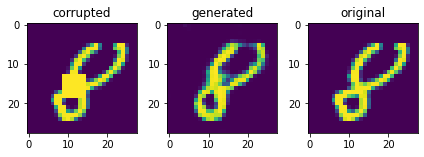

In [181]:
corrupted_images = corrupted_images.cuda()
for epoch in range(1, 1500+1):
    # z optimum
    optimizer_inpaint.zero_grad()
    generated_images = generator(z_optimum)
    discriminator_opinion = discriminator(generated_images)
    c_loss = context_loss(corrupted_images, generated_images, torch.tensor(weighted_masks).cuda())
    prior_loss = torch.sum(-torch.log(discriminator_opinion))
    inpaint_loss = c_loss + prior_loss
    inpaint_loss.backward()

    optimizer_inpaint.step()

    if epoch % 100==0:
        num_rnd = 0
        ploter(corrupted_images[num_rnd,0].detach().cpu(),
                   generated_images[num_rnd,0].detach().cpu(),
                   original_images[num_rnd,0].detach().cpu())

### End

In [ ]:
def image_gradient(image):
    a = torch.Tensor([[[[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]]]]).cuda()
    G_x = F.conv2d(image, a, padding=1)
    b = torch.Tensor([[[[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]]]]).cuda()
    G_y = F.conv2d(image, b, padding=1)
    return G_x, G_y

In [ ]:
def posisson_blending(masks,generated_images,corrupted_images):
    print("Starting Poisson blending ...")
    initial_guess = masks*corrupted_images + (1-masks)*generated_images
    image_optimum = nn.Parameter(torch.FloatTensor(initial_guess.detach().cpu().numpy()).cuda())
    optimizer_blending = optim.Adam([image_optimum])
    generated_grad_x, generated_grad_y = image_gradient(generated_images)

    for epoch in range(3000):
        optimizer_blending.zero_grad()
        image_optimum_grad_x, image_optimum_grad_y = image_gradient(image_optimum);
        blending_loss = torch.sum(((generated_grad_x-image_optimum_grad_x)**2 + (generated_grad_y-image_optimum_grad_y)**2)*(1-masks))
        blending_loss.backward()
        image_optimum.grad = image_optimum.grad*(1-masks)
        optimizer_blending.step()

        print("[Epoch: {}/{}] \t[Blending loss: {:.3f}]   \r".format(1+epoch, 3000, blending_loss), end="")
    print("")

    del optimizer_blending
    return image_optimum.detach()


In [ ]:
blended_images = posisson_blending(mask[0].cuda(), generated_images.detach(), corrupted_images)

In [ ]:
plt.figure()
plt.imshow(corrupted_images[0][0].detach().cpu())
plt.show()

plt.figure()
plt.imshow(generated_images[0][0].detach().cpu())
plt.show()

plt.figure()
plt.imshow(blended_images[0][0].detach().cpu())
plt.show()

plt.figure()
plt.imshow(original_images[0][0].detach().cpu())
plt.show()

In [ ]:
os.getcwd()

In [ ]:
dataset = torchvision.datasets.CelebA("./Celeb/test", 'test', download=True)

In [ ]:
dataset = torchvision.datasets.CelebA("./Celeb/train", 'train', download=True)

In [ ]:
dataset